In [30]:
from __future__ import print_function

import math
from IPython.core import display as ICD
from matplotlib  import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics

import tensorflow as tf
import tensorflow.python.data as tf_data
from tensorflow.keras import optimizers
tf.compat.v1.disable_eager_execution()
tf.compat.v1.get_logger().setLevel("ERROR")
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from IPython import display

# Predicción de los precios de la vivienda con regresión lineal 
 **Aprendizaje automático desde cero (Parte II)**

In [7]:
# Paso 1: cargamos el data frame
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format
california_housing_dataframe =  pd.read_csv("C:/Users/Usuario/Archivos en Jupyter/Tensorflow/input/housing.csv", sep=",")

In [8]:
# Paso 2: separamos los datos de entrenamiento y prueba
myfeature =california_housing_dataframe[["total_rooms"]]
feature_columns = [tf.feature_column.numeric_column("total_rooms")] 
targets = california_housing_dataframe["median_house_value"]

In [27]:
# Paso 3: definimos el optimizador
my_optimizer = optimizers.SGD(learning_rate=0.0000001, clipnorm=5.0)

In [28]:
# Paso 4: definimos el modelo de regresión
linear_regresor =tf.estimator.LinearRegressor(
    feature_columns=feature_columns,
    optimizer=my_optimizer
)

In [13]:
# Paso 5: definimos la función input
#Input , devuelven la forma del tensor en el tiempo de construcción, que puede ser parcialmente desconocida.

def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Entrena un modelo de regresión lineal.
  
    Argumentos:
      features: pandas DataFrame de características
      target: pandas DataFrame de objetivos
      batch_size: Tamaño de los lotes a pasar al modelo
      shuffle: Verdadero o Falso. Ya sea para mezclar los datos.
      num_epochs: Número de épocas para las que se deben repetir los datos. Ninguno = repetir indefinidamente
    Devoluciones:
      Tupla de (características, etiquetas) para el siguiente lote de datos
    """
  
    # Convierta los datos de pandas en un diccionario de matrices np.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = tf.compat.v1.data.Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(buffer_size=10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [30]:
# Paso 6: entrenar el modelo

# _ Almacenar el valor de la última expresión en intérprete.
_ = linear_regresor.train(
    input_fn = lambda:my_input_fn(myfeature, targets), # Lambda  son una forma corta de declarar funciones pequeñas y anónimas
    steps=100
)

c:\Users\Usuario\anaconda3\lib\site-packages\keras\engine\base_layer_v1.py:1684: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


In [31]:
# Paso 7: Evaluar el modelo

# crear una función input para prediccciones
# Nota: como solo se va a hacer una predicción para cada ejemplo
# no tenemos que repetir o mezclar los datops aqui

prediction_input_fn =lambda: my_input_fn(myfeature, targets, num_epochs=1, shuffle=False)

# llamar a predict() en el linear_regresor para hacer las predicciones
predictions = linear_regresor.predict(input_fn=prediction_input_fn)

# Formateamos las predicciones como un array np para que podamos calcular las métricas de error
predictions = np.array([item['predictions'][0] for item in predictions])

# imprimimos el error cuadrático medio y raiz error cuadratico medio
mean_squared_error = metrics.mean_squared_error(predictions, targets)
root_mean_squared_error = math.sqrt(mean_squared_error)
print("Error cuadrático medio (MSE) en datos de entrenamiento: %0.3f" % mean_squared_error)
print("Raíz del error cuadrático medio (RMSE) en datos de entrenamiento: %0.3f" % root_mean_squared_error)

Error cuadrático medio (MSE) en datos de entrenamiento: 56104774069.783
Raíz del error cuadrático medio (RMSE) en datos de entrenamiento: 236864.464


In [32]:
# Comparamos el RMSE con min y max de nuestros targets

min_house_value = california_housing_dataframe["median_house_value"].min()
max_house_value = california_housing_dataframe["median_house_value"].max()
min_max_difference = max_house_value - min_house_value

print("Minimo valor de casa: %0.3f" % min_house_value)
print("Maximo valor de casa: %0.3f" % max_house_value)
print("Diferencia entre el maximo y el minimo: %0.3f" % min_max_difference)
print("La diferencia entre el maximo y el minimo es: %0.3f" % root_mean_squared_error)

Minimo valor de casa: 14999.000
Maximo valor de casa: 500001.000
Diferencia entre el maximo y el minimo: 485002.000
La diferencia entre el maximo y el minimo es: 236864.464


# Creación de gráficas

In [53]:
calibration_data = pd.DataFrame()
calibration_data["predictions"] = pd.Series(predictions)
calibration_data["targets"] = pd.Series(targets)
calibration_data.describe()

,predictions,targets
0,0.0,452600.0
1,0.4,358500.0
2,0.1,352100.0
3,0.1,341300.0
4,0.1,342200.0


In [55]:
sample=california_housing_dataframe.sample(n=300)


In [56]:
#Obtenemos los valores minimo y máximo de total_rooms
x_0 = sample["total_rooms"].min()
x_1 = sample["total_rooms"].max()


In [57]:
#Recuperamos el peso y el sesgo final generado durante el entrenamiento
weight = linear_regresor.get_variable_value('linear/linear_model/total_rooms/weights')[0]
bias = linear_regresor.get_variable_value('linear/linear_model/bias_weights')

In [58]:
#Obtener los median_house_values predichos para los valores min y max total_rooms
# Tener en cuenta la fórmula de la regresión y=mx +b
y_0 = weight * x_0 + bias
y_1 = weight * x_1 + bias

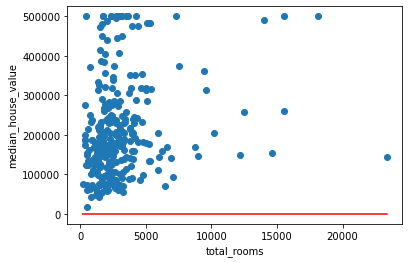

In [61]:

# Trazamos una linea de regresión desde (x_0, y_0) to (x_1, y_1).
plt.plot([x_0, x_1], [y_0, y_1], c='r')

# Nombramos los ejes del grafico.
plt.ylabel("median_house_value")
plt.xlabel("total_rooms")

#Trazamos una gráfica de dispersión de nuestros datos de ejemplo
plt.scatter(sample["total_rooms"], sample["median_house_value"])

# Display graph.
plt.show()

# Hiperparámetros

**Valores definidos antes del entrenamito** 
**Parametros estandar se calculan durante el entrenamiento**
**Pueden condicionarse entre sí**


Modificar los hiperparámetros del modelo
Para este ejercicio, hemos puesto todo el código anterior en una sola función por conveniencia. Puede llamar a la función con diferentes parámetros para ver el efecto.

En esta función, procederemos en 10 períodos divididos equitativamente para que podamos observar la mejora del modelo en cada período.

Para cada período, calcularemos y graficaremos la pérdida de entrenamiento. Esto puede ayudarlo a juzgar cuándo un modelo converge o si necesita más iteraciones.

También trazaremos los valores de los términos de peso y sesgo de la característica aprendidos por el modelo a lo largo del tiempo. Esta es otra forma de ver cómo convergen las cosas.

In [31]:
def train_model(learning_rate, steps, batch_size, input_feature="total_rooms"):
  """Entrena un modelo de regresión lineal de una característica.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    input_feature: A `string` specifying a column from `california_housing_dataframe`
      to use as input feature.
  """

  periods = 10
  steps_per_period = steps / periods

  my_feature = input_feature
  my_feature_data = california_housing_dataframe[[my_feature]]
  my_label = "median_house_value"
  targets = california_housing_dataframe[my_label]

  # Crear columnas de características.
  feature_columns = [tf.feature_column.numeric_column(my_feature)]
  
  # Crear funciones de entrada.
  training_input_fn = lambda:my_input_fn(my_feature_data, targets, batch_size=batch_size)
  prediction_input_fn = lambda: my_input_fn(my_feature_data, targets, num_epochs=1, shuffle=False)
  
  # Crear un objeto regresor lineal
  #my_optimizer = optimizers.SGD(learning_rate=learning_rate, clipnorm=5.0)

  from functools import partial

  my_optimizer = partial(optimizers.SGD, learning_rate=learning_rate, momentum=0.9, clipnorm=5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )

  # Configure para trazar el estado de la línea de nuestro modelo en cada período.
  plt.figure(figsize=(15, 6))
  plt.subplot(1, 2, 1)
  plt.title("Learned Line by Period")
  plt.ylabel(my_label)
  plt.xlabel(my_feature)
  sample = california_housing_dataframe.sample(n=300)
  plt.scatter(sample[my_feature], sample[my_label])
  colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]

  #Entrene el modelo, pero hágalo dentro de un ciclo para que podamos evaluar periódicamente
  # métricas de pérdidas.
  print("Training model...")
  print("RMSE (on training data):")
  root_mean_squared_errors = []
  for period in range (0, periods):
    # Entrene el modelo, comenzando desde el estado anterior.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )

    # Tome un descanso y calucle las predicciones.
    predictions = linear_regressor.predict(input_fn=prediction_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
    
    # calcule la pérdida.
    root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(predictions, targets))
    # Imprima la perdida actual
    print("  period %02d : %0.2f" % (period, root_mean_squared_error))
    #  Agrega las metricas de perdida desde este peridod a la lista
    root_mean_squared_errors.append(root_mean_squared_error)
    # Finalmente, realice un seguimiento de los pesos y sesgos a lo largo del tiempo.
    # Aplique algunas matemáticas para asegurarse de que los datos y la línea se representen correctamente.
    y_extents = np.array([0, sample[my_label].max()])
    
    weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
    
    bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

    x_extents = (y_extents - bias) / weight
    x_extents = np.maximum(np.minimum(x_extents,
                                      sample[my_feature].max()),
                           sample[my_feature].min())
    y_extents = weight * x_extents + bias
    plt.plot(x_extents, y_extents, color=colors[period]) 
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.subplot(1, 2, 2)
  plt.ylabel('RMSE')
  plt.xlabel('Periods')
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(root_mean_squared_errors)

  # Output a table with calibration data.
  calibration_data = pd.DataFrame()
  calibration_data["predictions"] = pd.Series(predictions)
  calibration_data["targets"] = pd.Series(targets)
  display.display(calibration_data.describe())

  print("Final RMSE (on training data): %0.2f" % root_mean_squared_error)

Training model...
RMSE (on training data):


c:\Users\Usuario\anaconda3\lib\site-packages\keras\engine\base_layer_v1.py:1684: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


  period 00 : 236661.15


c:\Users\Usuario\anaconda3\lib\site-packages\keras\engine\base_layer_v1.py:1684: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


  period 01 : 236363.25


c:\Users\Usuario\anaconda3\lib\site-packages\keras\engine\base_layer_v1.py:1684: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


  period 02 : 236058.92


c:\Users\Usuario\anaconda3\lib\site-packages\keras\engine\base_layer_v1.py:1684: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


  period 03 : 235754.50


c:\Users\Usuario\anaconda3\lib\site-packages\keras\engine\base_layer_v1.py:1684: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


  period 04 : 235450.42


c:\Users\Usuario\anaconda3\lib\site-packages\keras\engine\base_layer_v1.py:1684: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


  period 05 : 235146.72


c:\Users\Usuario\anaconda3\lib\site-packages\keras\engine\base_layer_v1.py:1684: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


  period 06 : 234843.41


c:\Users\Usuario\anaconda3\lib\site-packages\keras\engine\base_layer_v1.py:1684: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


  period 07 : 234540.49


c:\Users\Usuario\anaconda3\lib\site-packages\keras\engine\base_layer_v1.py:1684: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


  period 08 : 234237.95


c:\Users\Usuario\anaconda3\lib\site-packages\keras\engine\base_layer_v1.py:1684: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


  period 09 : 233935.81
Model training finished.


,predictions,targets
count,20640.0,20640.0
mean,3177.3,206855.8
std,2628.8,115395.6
min,3.6,14999.0
25%,1745.7,119600.0
50%,2564.2,179700.0
75%,3794.5,264725.0
max,47381.8,500001.0


Final RMSE (on training data): 233935.81


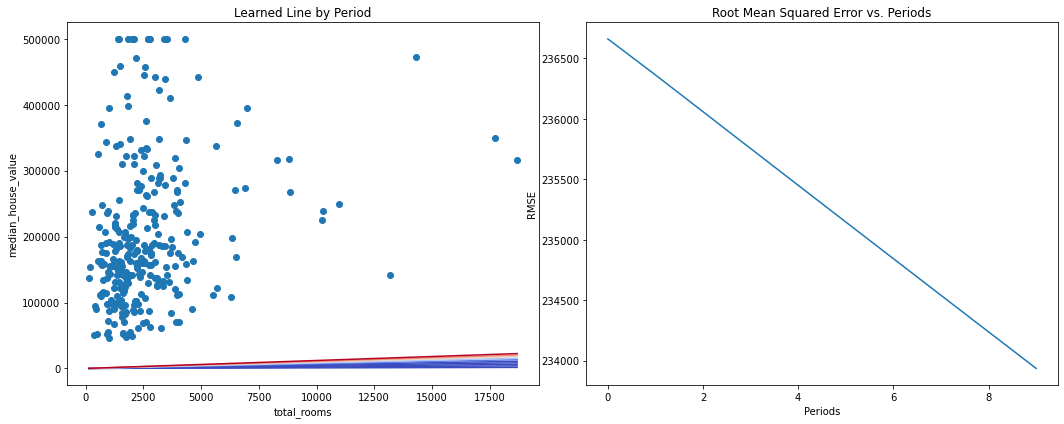

In [32]:
train_model(
    learning_rate=0.0001,
    steps=250,
    batch_size=10
)